In [1]:

import numpy as np

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv3D, ConvLSTM2D, BatchNormalization
from keras.models import Sequential

import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab_Notebooks/circular_motion.zip','r')
zip_train.extractall('/tmp')
zip_train.close()


In [42]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise

n_samples = 600
total_frames = 60
row = 128
col = 128
step = 2 #skip every other image to try to prevent subsequent frames looking too similar
n_frames = int(total_frames/step)
dataset = np.zeros((n_samples, n_frames, row, col), dtype=float) #define dataset array type

source_directory = "/tmp/circular_motion"

for folder_num in range(n_samples):
    folder_path = source_directory + "/" + str(folder_num)
    if os.path.isdir(folder_path):
        for idx in range(0,total_frames,step):
            file_path = folder_path + "/" + str(idx) + ".png"
            img = cv2.imread(file_path)

            # resize the image to 128x128
            img_resized = cv2.resize(img, (row, col))

            #GOING TO REMOVE BACKGROUND

            hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)

            # define the range of blue color in HSV (ball is blue)
            lower_blue = np.array([100, 50, 50])
            upper_blue = np.array([130, 255, 255])

            # create a mask for the blue color
            mask = cv2.inRange(hsv, lower_blue, upper_blue)

            # invert mask to get the background
            inverted_mask = cv2.bitwise_not(mask)

            # set all pixels to 0 where the mask is between threshold (background)
            img_processed = cv2.bitwise_and(img_resized, img_resized, mask=inverted_mask)

            # Convert the processed image to grayscale
            img_normalized = cv2.cvtColor(img_processed, cv2.COLOR_BGR2GRAY)
            img_normalized = img_normalized / 255.0

            # ADD SALT AND PEPPER NOISE
            img_noisy = random_noise(img_normalized, mode='s&p', amount=0.05)

            # assign the processed image to the dataset
            dataset[folder_num][int(idx/step)] = img_noisy

In [43]:
dataset = dataset[..., np.newaxis]
dataset.shape

(600, 30, 128, 128, 1)

In [44]:
X = dataset[:, 0:n_frames-1, :, :]
y = dataset[:, 1:n_frames, :, :]
print(X.shape)

(600, 29, 128, 128, 1)


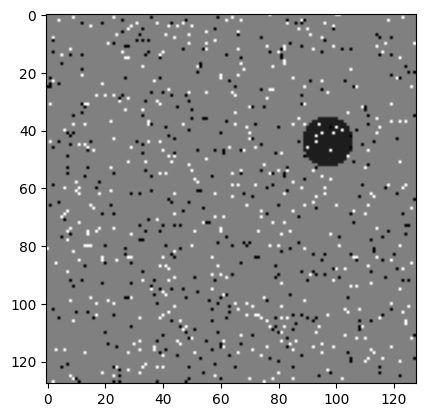

In [45]:
# Show example image
plt.imshow(dataset[79][0], cmap='gray')
plt.show()

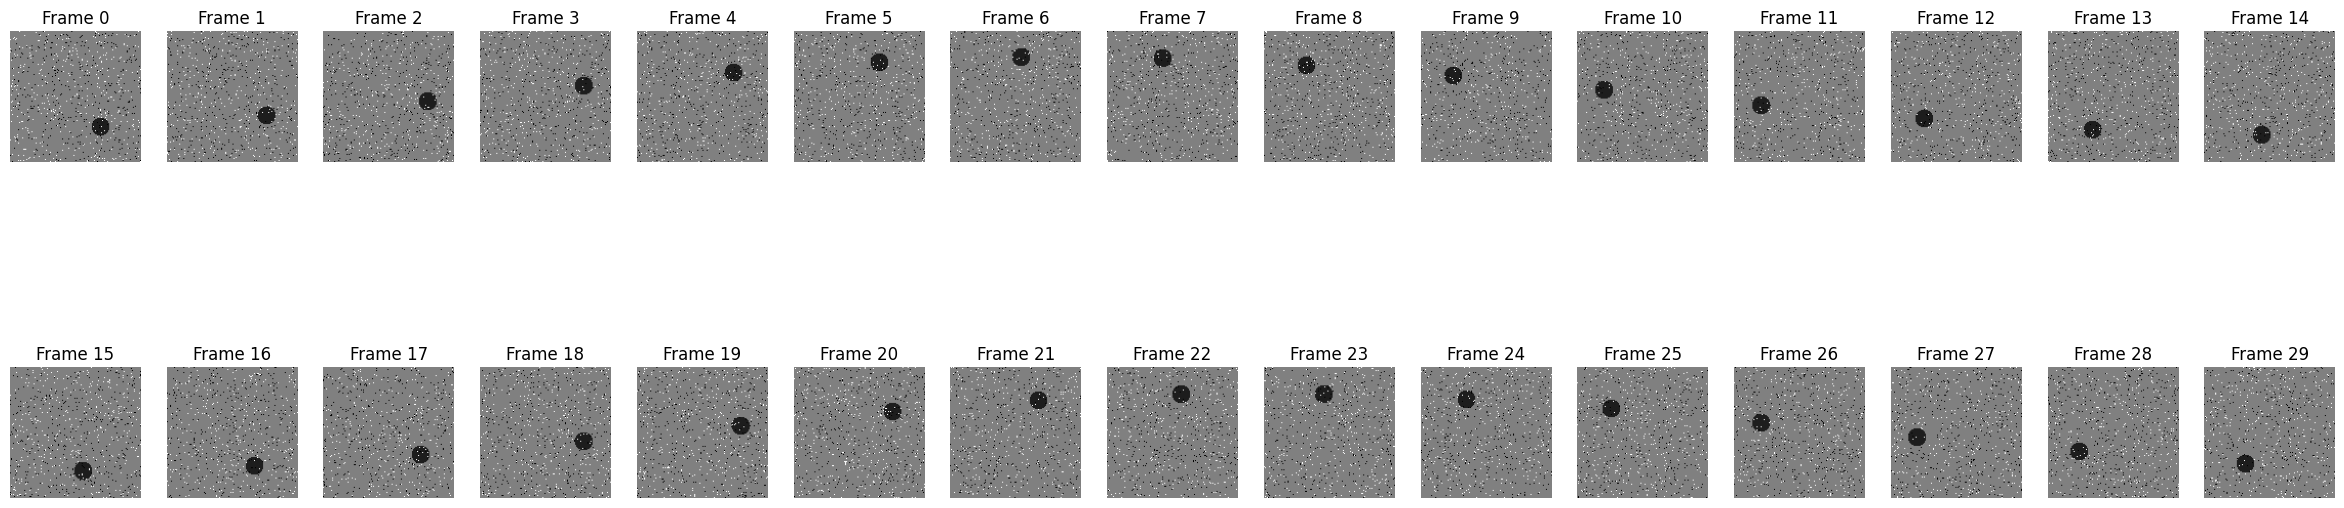

In [46]:
import math

images = dataset.shape[1]
half_images = math.ceil(images / 2)

# Create two rows of subplots
fig, axes = plt.subplots(2, half_images, figsize=(images, 8))

# Plot the top row
for idx in range(half_images):
    ax = axes[0, idx]
    ax.imshow(dataset[1][idx], cmap='gray')
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

# Plot the bottom row
for idx in range(half_images, images):
    ax = axes[1, idx - half_images]  # Adjust the index for the second row
    ax.imshow(dataset[1][idx], cmap='gray')
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

plt.show()


In [47]:
from keras.layers import Attention, GlobalAveragePooling3D, concatenate, Reshape, Flatten

seq = Sequential()

seq.add(ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   input_shape=(None, 128, 128, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

# Attempts to add Attention Layer (Not actually implemented properly)
attention = Attention()
conv_lstm_output = seq.get_layer(index=-2).output
attention_result = attention([conv_lstm_output, conv_lstm_output])
pooled_attention = GlobalAveragePooling3D()(attention_result)
flattened_conv_lstm = Flatten()(conv_lstm_output)
reshaped_attention = Reshape((1, 1, 64))(pooled_attention)
flattened_attention = Flatten()(reshaped_attention)
combined = concatenate([flattened_conv_lstm, flattened_attention])

# final Conv3D layer (apply sigmoid activation for prediction, 1 channel for B/W channel)
seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))
seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


Epoch 1/10
1/1 [==============================] - 0s 148ms/step


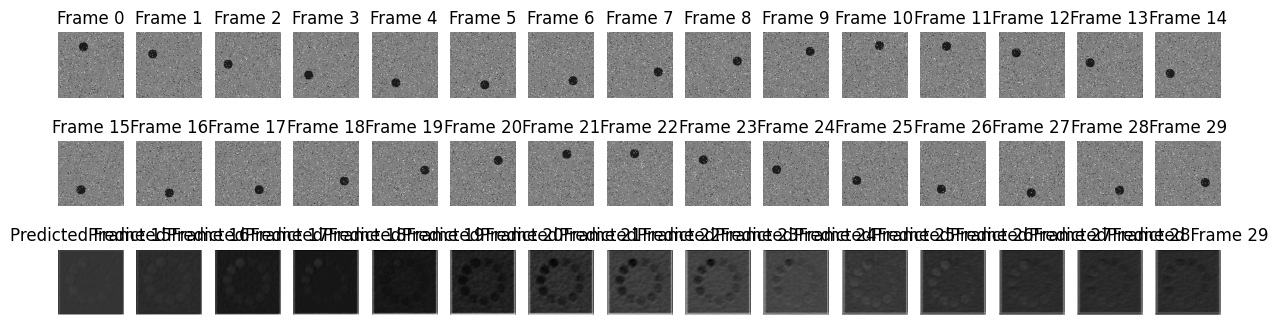

405/405 [==============================] - 233s 558ms/step - loss: 0.6858 - accuracy: 0.0353 - val_loss: 0.7456 - val_accuracy: 0.0266 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 0s 148ms/step


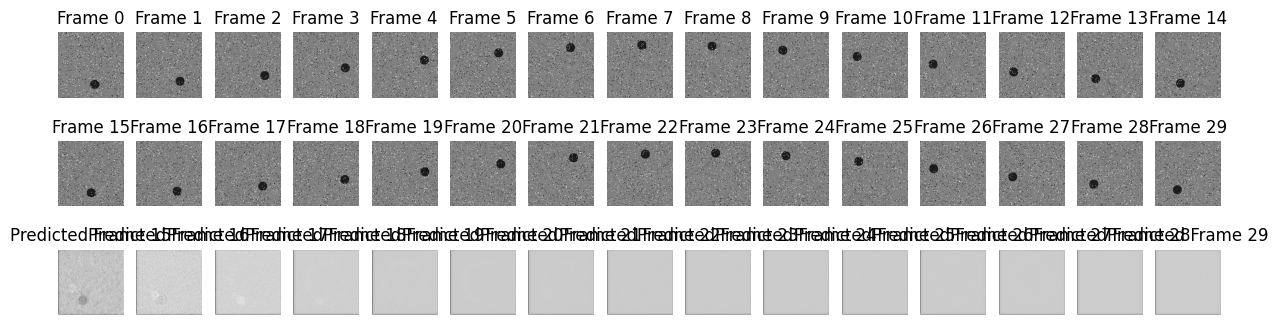

405/405 [==============================] - 223s 550ms/step - loss: 0.6582 - accuracy: 0.0487 - val_loss: 0.6859 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 147ms/step


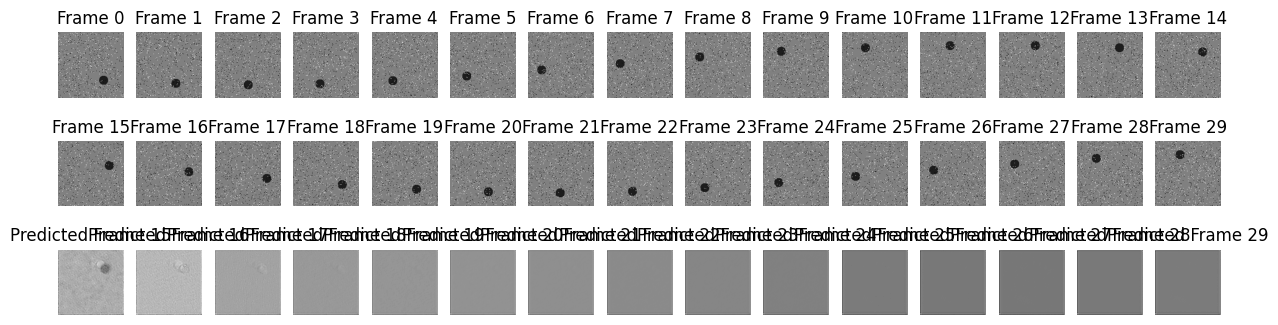

405/405 [==============================] - 223s 552ms/step - loss: 0.6561 - accuracy: 0.0491 - val_loss: 0.6594 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 0s 148ms/step


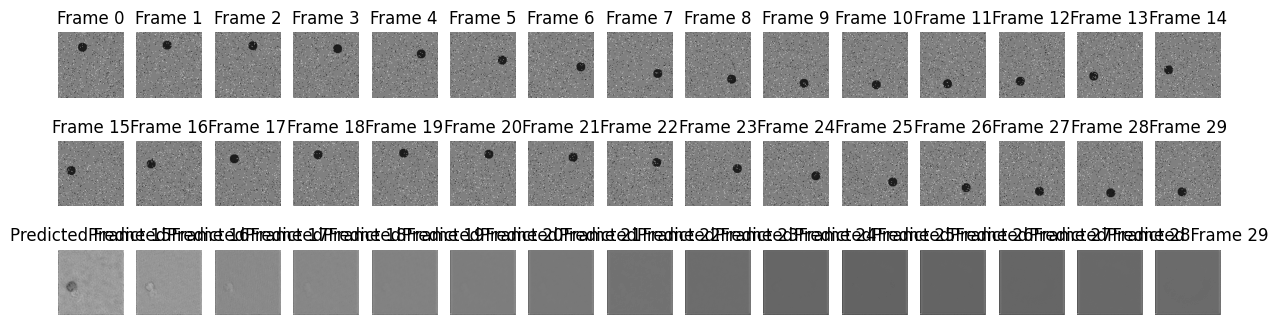

405/405 [==============================] - 223s 550ms/step - loss: 0.6557 - accuracy: 0.0491 - val_loss: 0.6567 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 0s 148ms/step


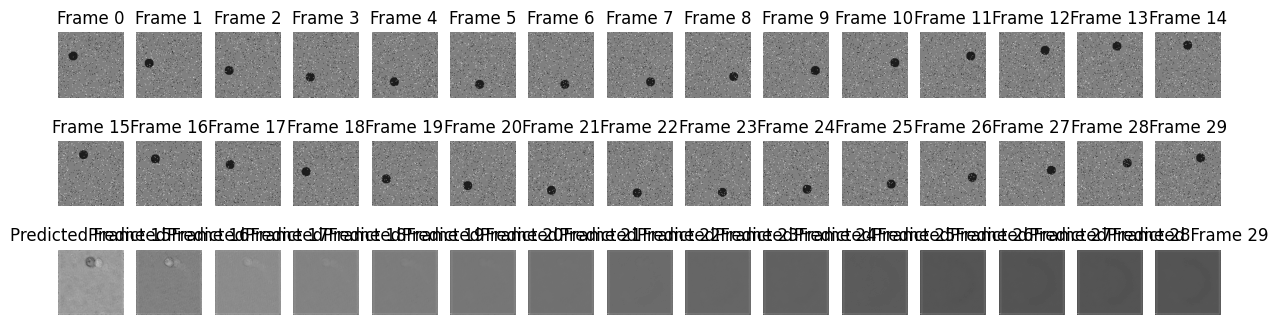

405/405 [==============================] - 223s 550ms/step - loss: 0.6556 - accuracy: 0.0491 - val_loss: 0.6563 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 0s 147ms/step


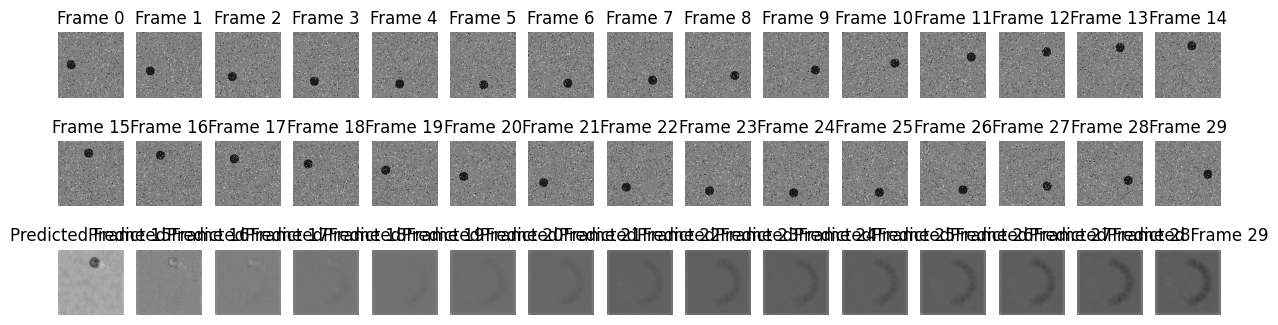

405/405 [==============================] - 224s 552ms/step - loss: 0.6556 - accuracy: 0.0491 - val_loss: 0.6572 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 0s 149ms/step


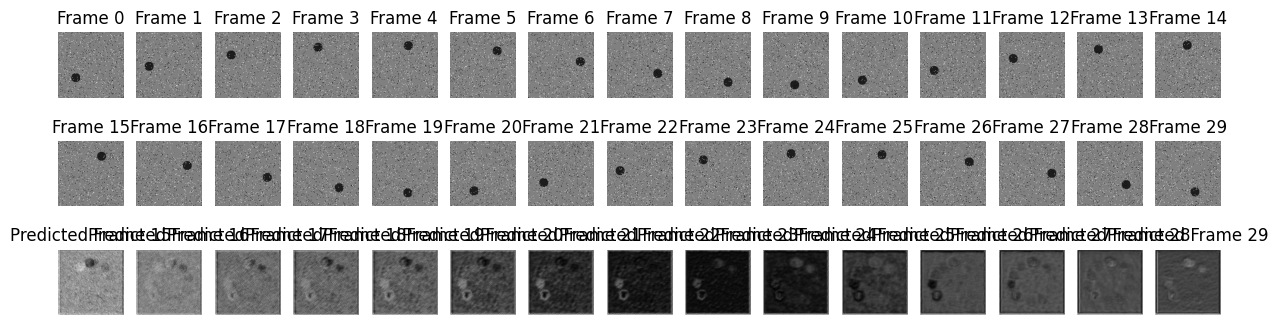

405/405 [==============================] - 223s 550ms/step - loss: 0.6563 - accuracy: 0.0491 - val_loss: 0.8511 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 8/10
1/1 [==============================] - 0s 147ms/step


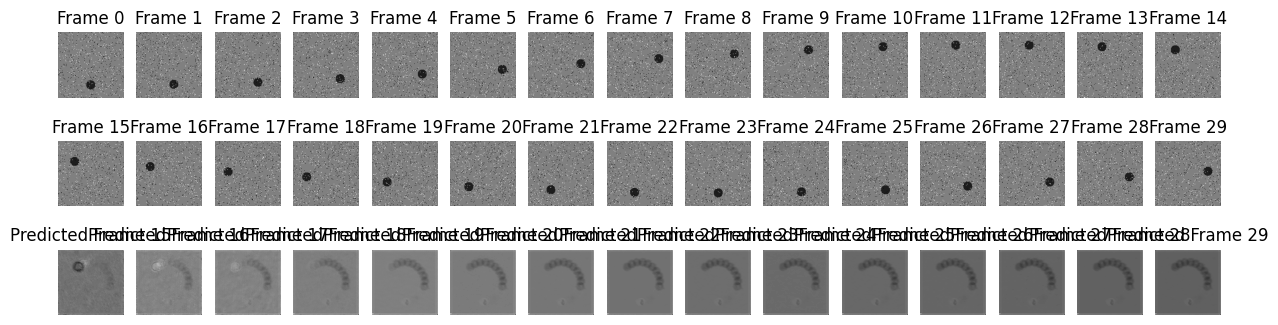

405/405 [==============================] - 223s 551ms/step - loss: 0.6557 - accuracy: 0.0491 - val_loss: 0.6555 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 9/10
1/1 [==============================] - 0s 148ms/step


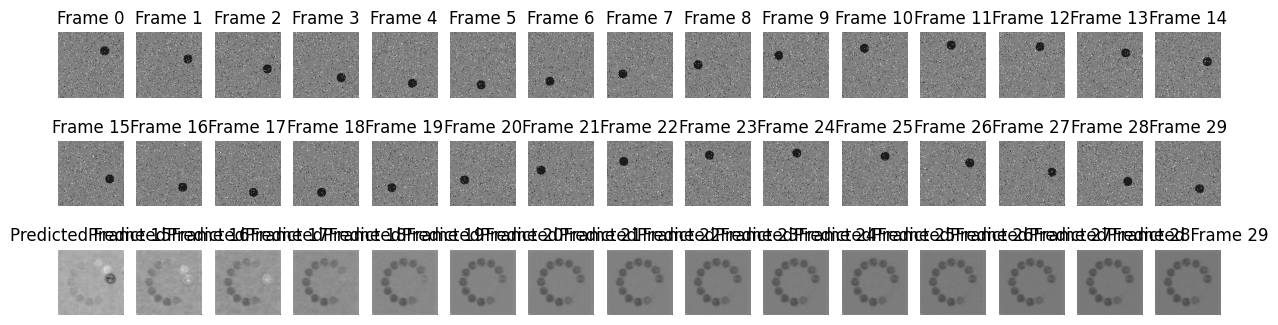

405/405 [==============================] - 224s 552ms/step - loss: 0.6554 - accuracy: 0.0491 - val_loss: 0.6554 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 10/10
1/1 [==============================] - 0s 149ms/step


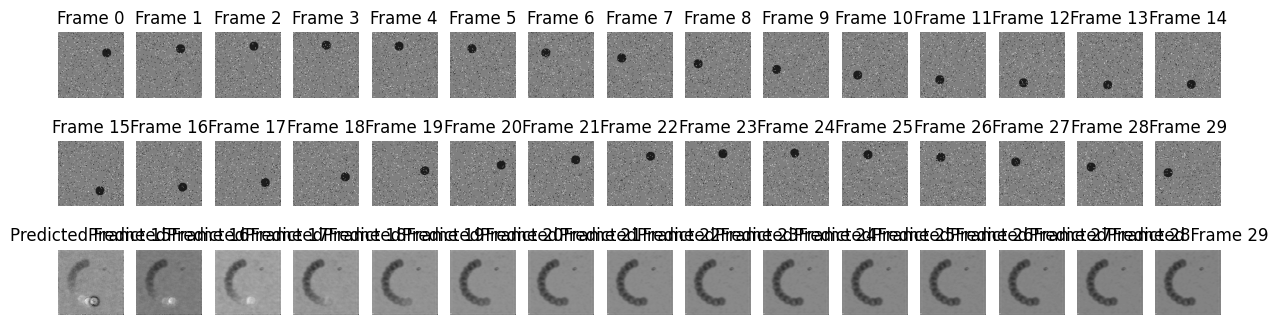

405/405 [==============================] - 223s 551ms/step - loss: 0.6554 - accuracy: 0.0491 - val_loss: 0.6596 - val_accuracy: 0.0492 - lr: 0.0010


In [48]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import math

images = dataset.shape[1]
half_imgs = math.ceil(images / 2)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 10
batch_size = 1

class PrintPredictionCallback(Callback):
    def __init__(self, dataset, half_imgs):
        super(PrintPredictionCallback, self).__init__()
        self.dataset = dataset
        self.half_imgs = half_imgs

    def on_epoch_end(self, epoch, logs=None):
        # select a random example from the testing dataset
        example = self.dataset[random.randrange(301, 599)]

        # pick the first/last 15 frames from the example
        frames = example[:self.half_imgs, ...]  # First 15
        original_frames = example[self.half_imgs:, ...]  # Last 15
        ogog_frames = example[:self.half_imgs, ...]  # First 15, unadulterated

        # predict next 15 frames
        for _ in range(self.half_imgs):
             # extract model's prediction and process it
            new_prediction = self.model.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # add to set of prediction frames for next prediction
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # construct a figure. Top row = original first 15
        # middle row = ground truth last 15 frames
        #bottom row = predicted last 15 frames
        fig, axes = plt.subplots(3, self.half_imgs, figsize=(self.half_imgs, 4))

        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx}")
            ax.axis("off")

        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx + self.half_imgs}")
            ax.axis("off")

        # plot the new frames.
        new_frames = frames[self.half_imgs:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"Predicted Frame {idx + self.half_imgs}")
            ax.axis("off")

        # display the figure.
        plt.show()

# create instance of custom callback function to print images at end of epoch
print_prediction_callback = PrintPredictionCallback(dataset, half_imgs)

# training
seq.fit(X[:450], y[:450], batch_size=1,
        epochs=epochs, validation_split=0.1, callbacks=[early_stopping, reduce_lr, print_prediction_callback])


1/1 [==============================] - 0s 148ms/step


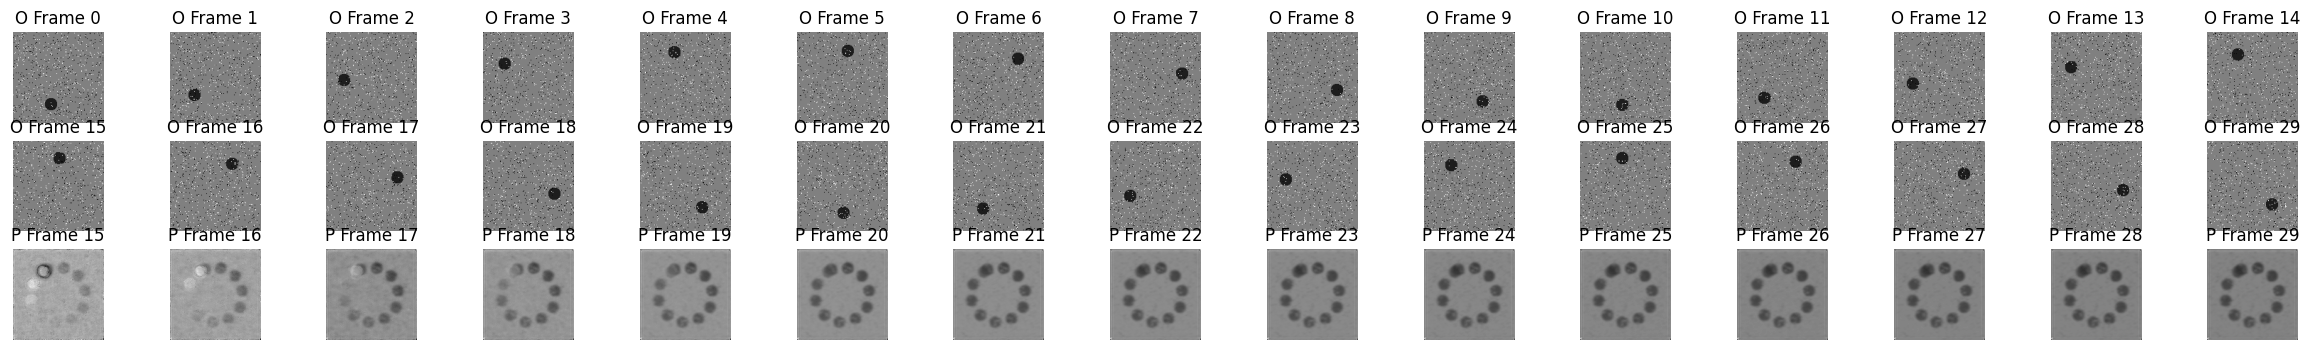

1/1 [==============================] - 0s 151ms/step


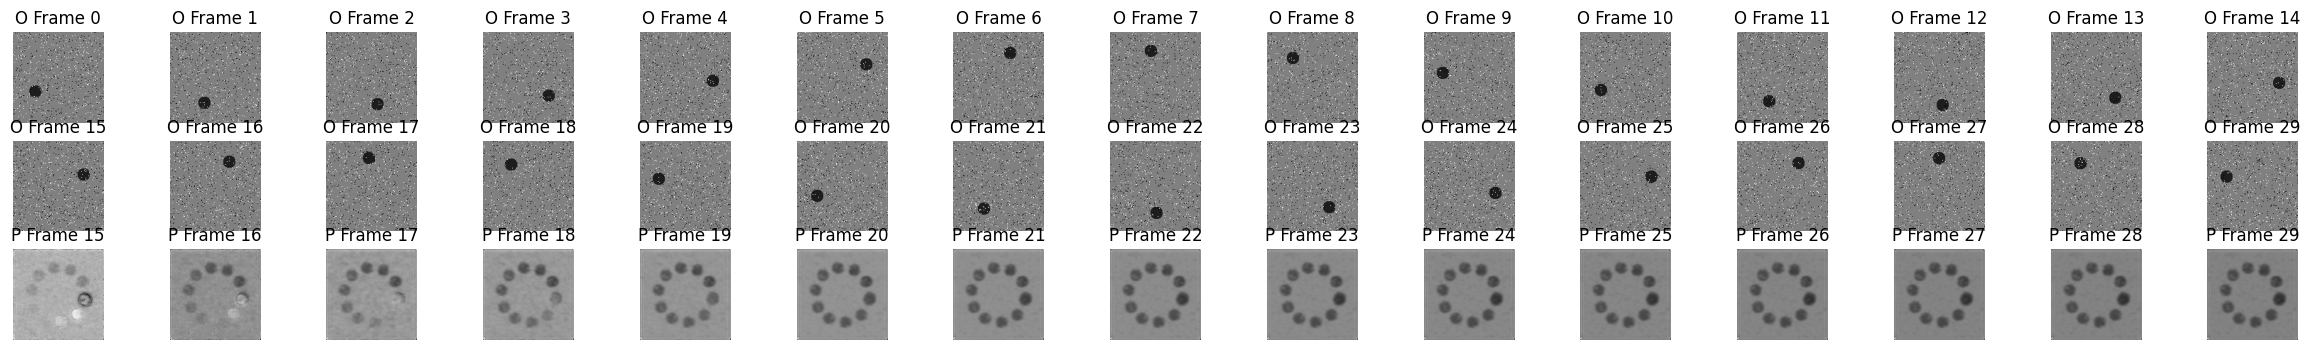

1/1 [==============================] - 0s 147ms/step


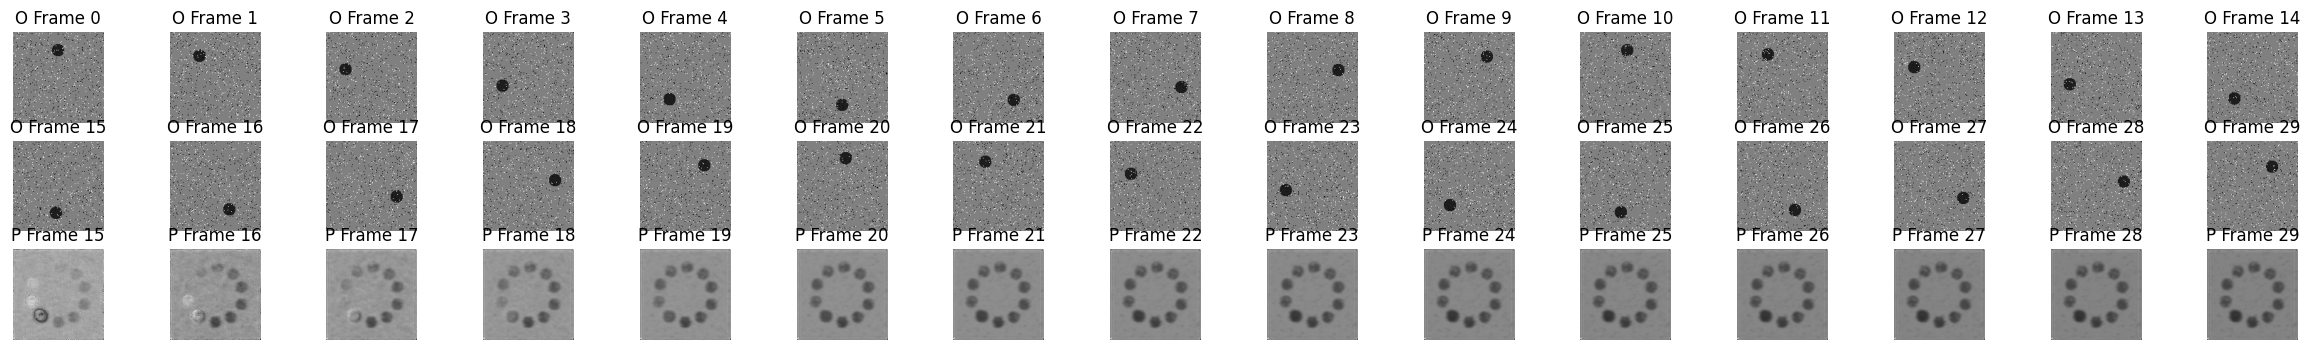

1/1 [==============================] - 0s 148ms/step


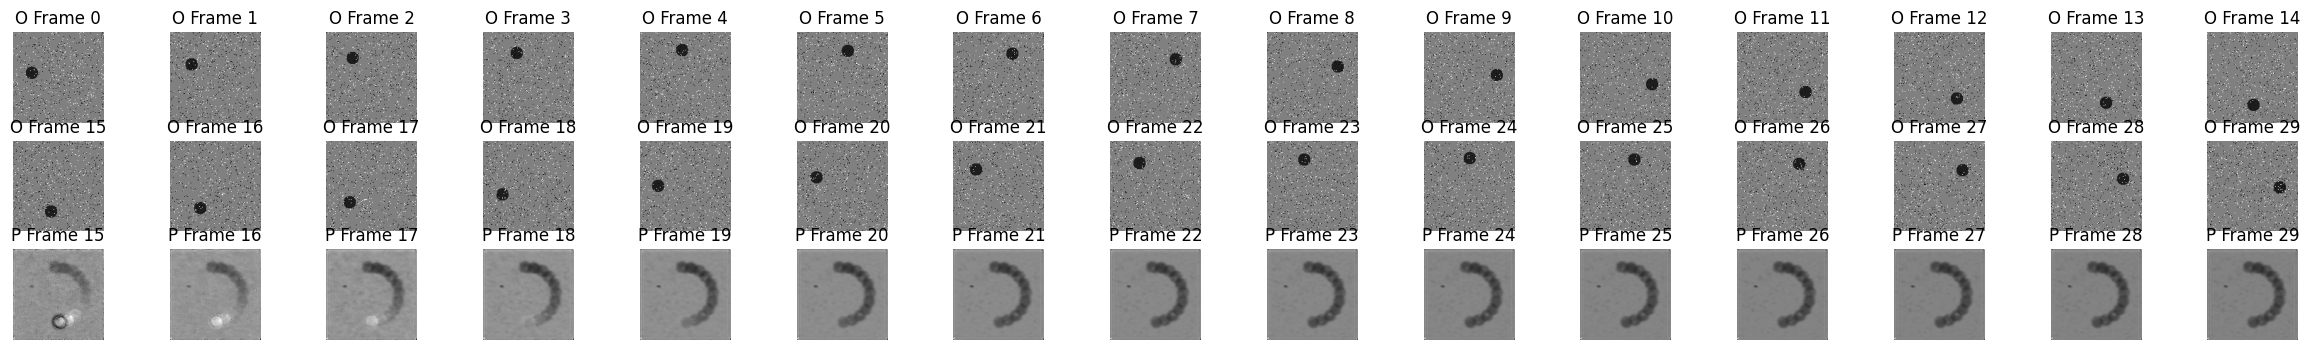

1/1 [==============================] - 0s 148ms/step


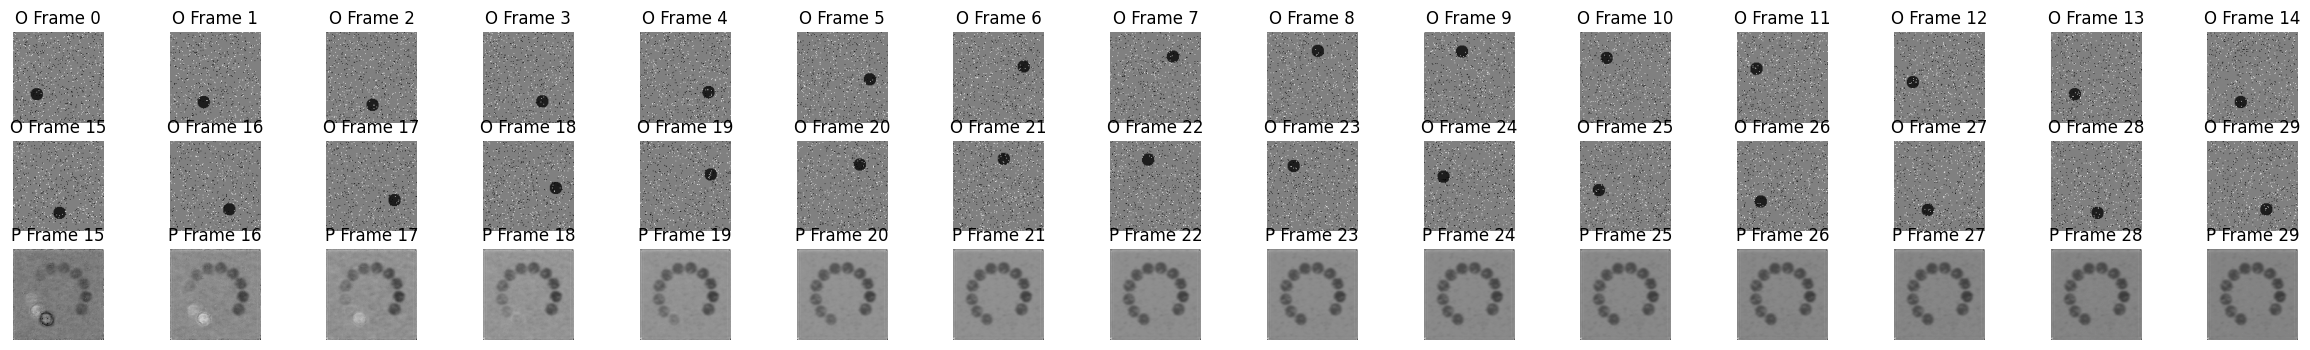

In [49]:
import random
from matplotlib.colors import LinearSegmentedColormap

# cmap = LinearSegmentedColormap.from_list("custom_colormap", ["black", "gray", "white"])


import math

samples = dataset.shape[0]

half_imgs = int(dataset.shape[1] / 2)

for i in range(5):
    # select a random example from the testing dataset
    example = dataset[random.randrange(math.floor(0.8*samples + 1), samples - 1)]


    # pick the first/last 15 frames (if total_frames=30) from the example
    frames = example[:half_imgs, ...] #first 15
    original_frames = example[half_imgs:, ...] #last 15
    ogog_frames = example[:half_imgs,...] #first 15, unadultered

    # predict next 15 frames
    for _ in range(half_imgs):
        # extract model's prediction and process it
        new_prediction = seq.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # add to set of prediction frames for next prediction
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # construct a figure. Top row = original first 15
    # middle row = ground truth last 15 frames
    #bottom row = predicted last 15 frames
    fig, axes = plt.subplots(3, half_imgs, figsize=(30, 4))

    # plot the original frames
    for idx, ax in enumerate(axes[0]):
          ax.imshow(ogog_frames[idx], cmap='gray')
          ax.set_title(f"O Frame {idx}")
          ax.axis("off")
    #plot ground truth frames
    for idx, ax in enumerate(axes[1]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"O Frame {idx + half_imgs}")
        ax.axis("off")

    # plot the new predicted frames
    new_frames = frames[half_imgs:, ...]
    for idx, ax in enumerate(axes[2]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"P Frame {idx + half_imgs}")
        ax.axis("off")

    # display the figure.
    index=0
    index += 1
    plt.show()

In [50]:
import random
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

import math

samples = dataset.shape[0]

half_imgs = int(dataset.shape[1] / 2)
# cmap = LinearSegmentedColormap.from_list("custom_colormap", ["black", "gray", "white"])

half_imgs = int(dataset.shape[1]/2)

# Create a PDF file to save the figures
with PdfPages('/output_frames_v19.pdf') as pdf:
    for i in range(30):
        # select a random example from the testing dataset
        example = dataset[random.randrange(math.floor(0.8*samples + 1), samples - 1)]

        # pick the first/last 15 frames from the example
        frames = example[:half_imgs, ...]  # first 15
        original_frames = example[half_imgs:, ...]  # last 15
        ogog_frames = example[:half_imgs, ...]  # first 15, unadulterated

        # predict next 15 frames
        for _ in range(half_imgs):
            # extract model's prediction and process it
            new_prediction = seq.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # add to set of prediction frames for next prediction
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # construct a figure. Top row = original first 15
        # middle row = ground truth last 15 frames
        #bottom row = predicted last 15 frames
        fig, axes = plt.subplots(3, 15, figsize=(30, 4))

        # plot the original frames
        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx}")
            ax.axis("off")
        
        #plot ground truth frames
        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx + 15}")
            ax.axis("off")

        # plot predicted frames
        new_frames = frames[15:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"P Frame {idx + 15}")
            ax.axis("off")

        # display the figure.
        pdf.savefig()
        plt.close()

1/1 [==============================] - 0s 147ms/step


In [ ]:
seq.save('/model_circular.keras')